In [1]:
import os
os.chdir("/home/ubuntu/code/pump_post_midterm/pump")

import json
import bnlearn as bn
import pandas as pd
import networkx as nx
import copy
from tqdm import tqdm


In [2]:
# persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0729_midterm_personas_full_sonnet.json'
# persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0828_personas_American_Trends_Panel_W26_testonly_haiku.json'
persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0828_personas_American_Trends_Panel_W26_testonly_haiku.json'

with open(persona_filename, 'r') as f:
    data = json.load(f)
data[list(data.keys())[0]]

[{'name': 'Personal Values Regarding Firearms',
  'description': "The participant's core values and beliefs that shape their attitudes and behaviors towards firearm ownership, use, and safety, such as personal freedom, public safety, self-reliance, and responsible gun ownership.",
  'level': 'high',
  'candidate_values': ['values personal freedom',
   'values public safety',
   'values self-reliance and personal protection',
   'values responsible gun ownership'],
  'inferred_value': 'values public safety'},
 {'name': 'Attitudes Towards Firearms',
  'description': "The participant's overall beliefs, opinions, and feelings about guns and their role in society, including views on gun ownership, gun control, and the broader cultural attitudes towards firearms.",
  'level': 'high',
  'candidate_values': ['pro-gun', 'anti-gun', 'neutral'],
  'inferred_value': 'anti-gun'},
 {'name': 'Personality Traits',
  'description': "The participant's general disposition, including their level of anxiet

# Data Preprocessing

In [3]:
# verify data

def verify(data):
    ok_cnt = 0
    wrong_cnt = 0
    for user in data:
        for persona in data[user]:
            # if all(_ not in persona['candidate_values'] for _ in [persona['inferred_value'], persona['inferred_value'][1:-1]]):
            if persona['inferred_value'] not in persona['candidate_values']:
                wrong_cnt += 1
                print(persona)
                print(f"|{persona['inferred_value']}|")
                print(persona['candidate_values'])
                print()
            else:
                ok_cnt += 1

    print(ok_cnt, wrong_cnt)

verify(data)

{'name': 'Firearm Ownership Motivations', 'description': 'The primary reasons and purposes for owning firearms, such as hunting, self-defense, sport shooting, or collecting.', 'level': 'mid', 'candidate_values': ['hunting', 'self-defense', 'sport shooting', 'collection', 'other'], 'inferred_value': 'no guns'}
|no guns|
['hunting', 'self-defense', 'sport shooting', 'collection', 'other']

{'name': 'Perception of Crime Trends', 'description': 'How the participant perceives the overall level of crime and safety in the world compared to the past, which may shape their views on gun ownership.', 'level': 'mid', 'candidate_values': ['world is safer', 'world is more dangerous', 'world is neither safer nor more dangerous'], 'inferred_value': 'more dangerous'}
|more dangerous|
['world is safer', 'world is more dangerous', 'world is neither safer nor more dangerous']

{'name': 'Firearm Ownership Motivations', 'description': 'The primary reasons and purposes for owning firearms, such as hunting, s

In [4]:
# clean data

def clean(data):
    temp_data = copy.deepcopy(data)
    for user in data.keys():
        personas = data[user]
        clean = []
        seen_personas = []
        for p in personas:
            if f"{p['level']}/{p['name']}" in seen_personas:
                continue
            inf_val = p['inferred_value']
            cands = p['candidate_values']
            if len(cands) > 5:
                continue
            if inf_val not in cands:
                if inf_val[1:-1] in cands and all(_ in ['\'', '\"'] for _ in [inf_val[0], inf_val[-1]]):
                    p['inferred_value'] = inf_val[1:-1]
                    clean.append(p)
                    seen_personas.append(f"{p['level']}/{p['name']}")
            else:
                clean.append(p)
                seen_personas.append(f"{p['level']}/{p['name']}")
        temp_data[user] = clean
    return temp_data

cleaned_data = clean(data)
verify(cleaned_data)

38831 0


In [5]:
for user in cleaned_data:
    for idx, p in enumerate(cleaned_data[user]):
        if p['inferred_value'] not in p['candidate_values']:
            print(user, idx, p['name'], p['inferred_value'], p['candidate_values'], p)

len(set([f"{p['level']}/{p['name']}" for user in cleaned_data for p in cleaned_data[user]]))

100

In [6]:
cleaned_data['2820']

[{'name': 'Personal Values Regarding Firearms',
  'description': "The participant's core values and beliefs that shape their attitudes and behaviors towards firearm ownership, use, and safety, such as personal freedom, public safety, self-reliance, and responsible gun ownership.",
  'level': 'high',
  'candidate_values': ['values personal freedom',
   'values public safety',
   'values self-reliance and personal protection',
   'values responsible gun ownership'],
  'inferred_value': 'values public safety'},
 {'name': 'Attitudes Towards Firearms',
  'description': "The participant's overall beliefs, opinions, and feelings about guns and their role in society, including views on gun ownership, gun control, and the broader cultural attitudes towards firearms.",
  'level': 'high',
  'candidate_values': ['pro-gun', 'anti-gun', 'neutral'],
  'inferred_value': 'anti-gun'},
 {'name': 'Personality Traits',
  'description': "The participant's general disposition, including their level of anxiet

In [7]:
# categorize_data

idx2opt_mapping = {}
opt2idx_mapping = {}

for user in cleaned_data:
    for persona in cleaned_data[user]:
        p_name = f"{persona['level']}/{persona['name']}"
        if p_name in idx2opt_mapping:
            continue
        cands = persona['candidate_values']
        idx2opt = {k+1: v for k, v in enumerate(cands)}  # 0 for potential NAs
        idx2opt[0] = "Unknown"
        idx2opt_mapping[p_name] = idx2opt
        opt2idx_mapping[p_name] = {v: k for k, v in idx2opt.items()}



In [8]:
def categorize(data):
    categorized_data = copy.deepcopy(data)
    for user in data:
        personas = data[user]
        clean = []
        for idx, p in enumerate(personas):
            p_name = f"{p['level']}/{p['name']}"
            inf_val = p['inferred_value']
            try:
                p['inferred_value'] = opt2idx_mapping[p_name][inf_val]
            except:
                print(user, p_name, idx, inf_val)
                # print(p_name, p_name in opt2idx_mapping)
                # print(inf_val, inf_val in opt2idx_mapping[p_name])
                # print(opt2idx_mapping[p_name])
                print(p)
            clean.append(p)
        categorized_data[user] = clean
    return categorized_data

categorized_data = categorize(cleaned_data)

In [9]:
res = []

for user in categorized_data.keys():
    entry = {'user': user}
    for persona in categorized_data[user]:
        entry[f"{persona['level']}/{persona['name']}"] = persona['inferred_value']
    res.append(entry)

raw_df = pd.DataFrame(res)
raw_df.fillna(0, inplace=True)
raw_df = raw_df.astype(int)
df = raw_df[[_ for _ in raw_df.columns if _ is not "user"]]
df

import copy

initial_df = copy.deepcopy(df)

# Creating BN

In [10]:

def get_bn(df, method, score):

    model = bn.structure_learning.fit(df, methodtype=method, scoretype=score, tabu_length=100)
    # Plot detected DAG
    pos = nx.spring_layout(model['adjmat'])
    G = bn.plot(model, pos=pos)
    dirs = []
    for edge in G['edge_properties']:
        s, t = edge
        s = s.split('/')[0]
        t = t.split('/')[0]
        dirs.append(f"{s}_{t}")


    # Compute edge strength using chi-square independence test
    model1 = bn.independence_test(model, df, alpha=0.05, prune=True)
    pos = nx.spring_layout(model['adjmat'])
    G1 = bn.plot(model, pos=pos)
    dirs = []
    for edge in G1['edge_properties']:
        s, t = edge
        s = s.split('/')[0]
        t = t.split('/')[0]
        dirs.append(f"{s}_{t}")


    param_model = bn.parameter_learning.fit(model1, df)

    return param_model, dirs


In [11]:

def get_matrix(dirs):

    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from collections import Counter

    # Define the confusion matrix data
    data = Counter(dirs)

    # Create a confusion matrix array
    matrix = np.array([
        [data['high_high'], data['high_mid'], data['high_low']],
        [data['mid_high'], data['mid_mid'], data['mid_low']],
        [data['low_high'] if 'low_high' in data else 0, data['low_mid'], data['low_low']]
    ])

    # Define the labels for the axes
    labels = ['high', 'mid', 'low']

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Target')
    plt.ylabel('Source')
    plt.title('Edge source target matrix')
    plt.show()


In [12]:
def get_topo(model):

    import matplotlib.pyplot as plt
    import networkx as nx

    adjmat_df = model['adjmat']
    adjmat_numeric_df = adjmat_df.astype(int)
    G = nx.from_pandas_adjacency(adjmat_numeric_df, create_using=nx.DiGraph)

    topological_sorted_nodes = list(nx.topological_sort(G))
    pos = {node: (i, 0) for i, node in enumerate(topological_sorted_nodes)}

    plt.figure(figsize=(250, 30))

    # Define a color map based on node names
    node_colors = []
    for node in G.nodes:
        if node.startswith('low/'):
            node_colors.append('pink')
        elif node.startswith('mid/'):
            node_colors.append('gold')
        elif node.startswith('high/'):
            node_colors.append('lightblue')
        else:
            node_colors.append('lightblue')  # Default color

    # Draw the graph with node colors
    nx.draw(
        G, pos, 
        with_labels=False, 
        node_size=3000, 
        node_color=node_colors,  # Use the custom color map
        font_size=10, 
        font_weight='bold', 
        arrowsize=20, 
        connectionstyle='arc3,rad=0.2'  # Add this line to create curved arrows
    )

    # Annotate the nodes with their labels
    for label in pos:
        x, y = pos[label]
        plt.text(x, y, s=label, bbox=dict(facecolor='lightgray', alpha=0.5), 
                horizontalalignment='center', fontsize=8, rotation=15)

    plt.title("Bayesian Network with Topological Sort Layout")
    plt.show()



In [13]:
len(set(df.columns))

100

# Get new values (EM)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bds]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Existing coordinates from <pos> are used.


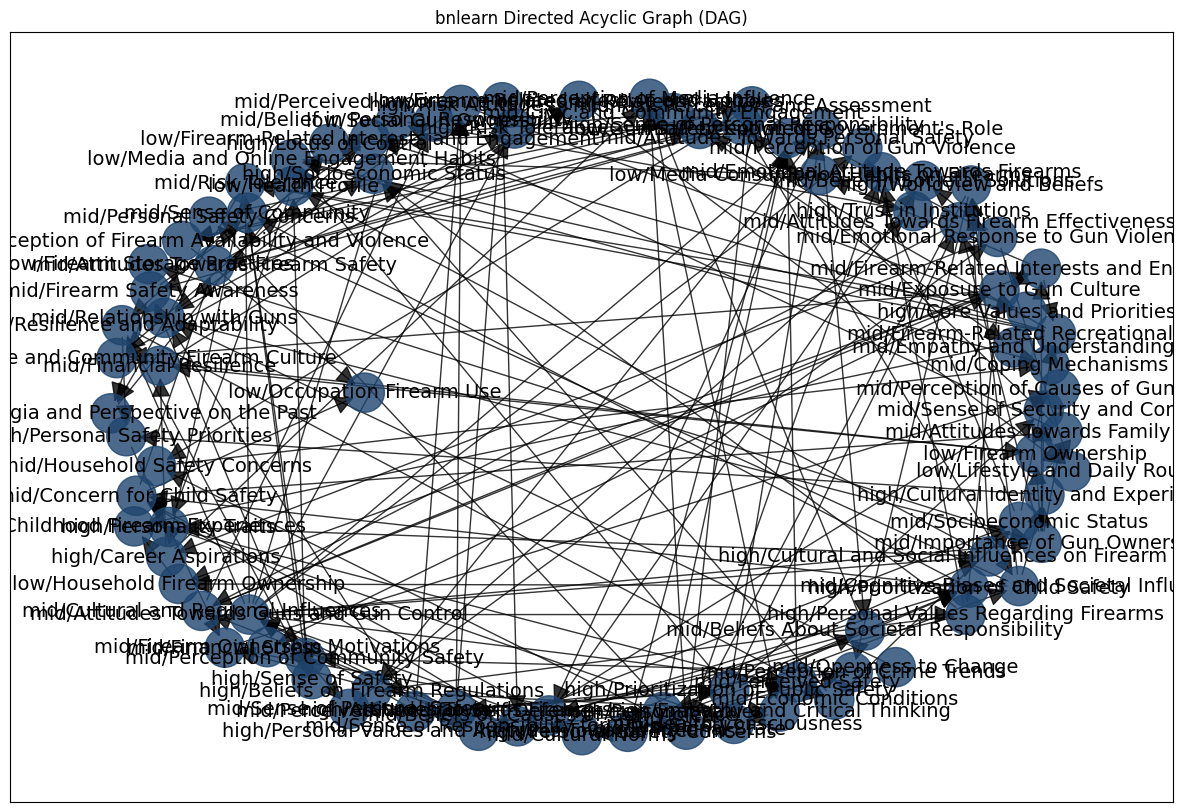

[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Edge [high/Beliefs on Firearm Regulations <-> mid/Emotional Response to Gun Violence] [P=0.0923096] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Concern for Child Safety <-> mid/Attitudes Towards Family Values] [P=0.4889] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Concern for Child Safety <-> low/Occupation Firearm Use] [P=0.429678] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Belief in Personal Responsibility <-> high/Trust in Institutions] [P=0.166565] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Civic and Community Engagement <-> mid/Empathy and Understanding] [P=1] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Sense of Personal Safety <-> high/Trust in Institutions] [P=0.132563] is excluded bec

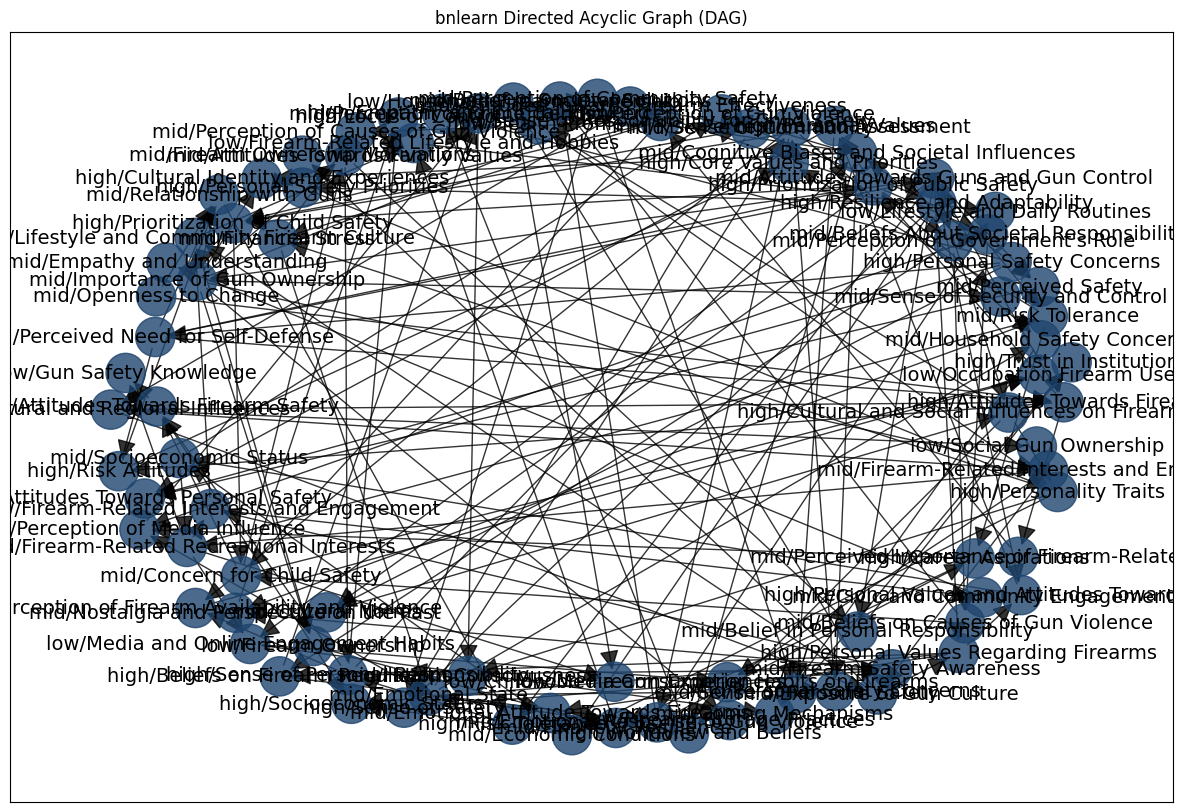

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.


[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. 

[bnlearn] >CPD of high/Personal Values Regarding Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Socioeconomic Status:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Personal Values and Attitudes Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Beliefs on Firearm Regulations:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of mid/Emotional Attitude Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Attitudes Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Risk Attitudes:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Prioritization

  0%|          | 0/72 [00:00<?, ?it/s]

[bnlearn]> Remaining columns for inference: 15


  1%|▏         | 1/72 [00:03<04:04,  3.45s/it]

[bnlearn]> Remaining columns for inference: 15


  3%|▎         | 2/72 [00:07<04:38,  3.98s/it]

[bnlearn]> Remaining columns for inference: 15


  4%|▍         | 3/72 [00:11<04:12,  3.66s/it]

[bnlearn]> Remaining columns for inference: 15


  6%|▌         | 4/72 [00:14<04:07,  3.64s/it]

[bnlearn]> Remaining columns for inference: 15


  7%|▋         | 5/72 [00:20<04:51,  4.36s/it]

[bnlearn]> Remaining columns for inference: 15


  8%|▊         | 6/72 [00:23<04:31,  4.11s/it]

[bnlearn]> Remaining columns for inference: 15


 10%|▉         | 7/72 [00:27<04:07,  3.80s/it]

[bnlearn]> Remaining columns for inference: 15


 11%|█         | 8/72 [00:30<03:49,  3.59s/it]

[bnlearn]> Remaining columns for inference: 15


 12%|█▎        | 9/72 [00:33<03:37,  3.45s/it]

[bnlearn]> Remaining columns for inference: 15


 14%|█▍        | 10/72 [00:36<03:34,  3.47s/it]

[bnlearn]> Remaining columns for inference: 15


 15%|█▌        | 11/72 [00:39<03:24,  3.35s/it]

[bnlearn]> Remaining columns for inference: 15


 17%|█▋        | 12/72 [00:43<03:29,  3.50s/it]

[bnlearn]> Remaining columns for inference: 15


 18%|█▊        | 13/72 [00:49<03:59,  4.07s/it]

[bnlearn]> Remaining columns for inference: 15


 19%|█▉        | 14/72 [00:52<03:44,  3.88s/it]

[bnlearn]> Remaining columns for inference: 15


 21%|██        | 15/72 [00:55<03:29,  3.68s/it]

[bnlearn]> Remaining columns for inference: 15


 22%|██▏       | 16/72 [00:59<03:20,  3.58s/it]

[bnlearn]> Remaining columns for inference: 15


 24%|██▎       | 17/72 [01:02<03:15,  3.55s/it]

[bnlearn]> Remaining columns for inference: 15


 25%|██▌       | 18/72 [01:06<03:18,  3.68s/it]

[bnlearn]> Remaining columns for inference: 15


 26%|██▋       | 19/72 [01:10<03:20,  3.78s/it]

[bnlearn]> Remaining columns for inference: 15


 28%|██▊       | 20/72 [01:14<03:15,  3.77s/it]

[bnlearn]> Remaining columns for inference: 15


 29%|██▉       | 21/72 [01:17<03:08,  3.69s/it]

[bnlearn]> Remaining columns for inference: 15


 31%|███       | 22/72 [01:21<02:56,  3.53s/it]

[bnlearn]> Remaining columns for inference: 15


 32%|███▏      | 23/72 [01:24<02:55,  3.58s/it]

[bnlearn]> Remaining columns for inference: 15


 33%|███▎      | 24/72 [01:28<02:55,  3.66s/it]

[bnlearn]> Remaining columns for inference: 15


 35%|███▍      | 25/72 [01:31<02:47,  3.56s/it]

[bnlearn]> Remaining columns for inference: 15


 36%|███▌      | 26/72 [01:35<02:41,  3.52s/it]

[bnlearn]> Remaining columns for inference: 15


 38%|███▊      | 27/72 [01:38<02:37,  3.49s/it]

[bnlearn]> Remaining columns for inference: 15


 39%|███▉      | 28/72 [01:41<02:29,  3.40s/it]

[bnlearn]> Remaining columns for inference: 15


 40%|████      | 29/72 [01:46<02:34,  3.59s/it]

[bnlearn]> Remaining columns for inference: 15


 42%|████▏     | 30/72 [01:49<02:30,  3.59s/it]

[bnlearn]> Remaining columns for inference: 15


 43%|████▎     | 31/72 [01:53<02:32,  3.71s/it]

[bnlearn]> Remaining columns for inference: 15


 44%|████▍     | 32/72 [01:56<02:22,  3.57s/it]

[bnlearn]> Remaining columns for inference: 15


 46%|████▌     | 33/72 [02:00<02:15,  3.47s/it]

[bnlearn]> Remaining columns for inference: 15


 47%|████▋     | 34/72 [02:03<02:15,  3.55s/it]

[bnlearn]> Remaining columns for inference: 15


 49%|████▊     | 35/72 [02:07<02:14,  3.64s/it]

[bnlearn]> Remaining columns for inference: 15


 50%|█████     | 36/72 [02:10<02:06,  3.51s/it]

[bnlearn]> Remaining columns for inference: 15


 51%|█████▏    | 37/72 [02:14<02:01,  3.46s/it]

[bnlearn]> Remaining columns for inference: 15


 53%|█████▎    | 38/72 [02:17<01:57,  3.44s/it]

[bnlearn]> Remaining columns for inference: 15


 54%|█████▍    | 39/72 [02:21<01:56,  3.54s/it]

[bnlearn]> Remaining columns for inference: 15


 56%|█████▌    | 40/72 [02:24<01:50,  3.45s/it]

[bnlearn]> Remaining columns for inference: 15


 57%|█████▋    | 41/72 [02:27<01:44,  3.36s/it]

[bnlearn]> Remaining columns for inference: 15


 58%|█████▊    | 42/72 [02:31<01:44,  3.48s/it]

[bnlearn]> Remaining columns for inference: 15


 60%|█████▉    | 43/72 [02:35<01:47,  3.72s/it]

[bnlearn]> Remaining columns for inference: 15


 61%|██████    | 44/72 [02:39<01:41,  3.63s/it]

[bnlearn]> Remaining columns for inference: 15


 62%|██████▎   | 45/72 [02:42<01:35,  3.54s/it]

[bnlearn]> Remaining columns for inference: 15


 64%|██████▍   | 46/72 [02:46<01:37,  3.76s/it]

[bnlearn]> Remaining columns for inference: 15


 65%|██████▌   | 47/72 [02:50<01:35,  3.83s/it]

[bnlearn]> Remaining columns for inference: 15


 67%|██████▋   | 48/72 [02:54<01:29,  3.74s/it]

[bnlearn]> Remaining columns for inference: 15


 68%|██████▊   | 49/72 [02:58<01:28,  3.84s/it]

[bnlearn]> Remaining columns for inference: 15


 69%|██████▉   | 50/72 [03:02<01:23,  3.81s/it]

[bnlearn]> Remaining columns for inference: 15


 71%|███████   | 51/72 [03:05<01:16,  3.62s/it]

[bnlearn]> Remaining columns for inference: 15


 72%|███████▏  | 52/72 [03:08<01:10,  3.51s/it]

[bnlearn]> Remaining columns for inference: 15


 74%|███████▎  | 53/72 [03:11<01:05,  3.44s/it]

[bnlearn]> Remaining columns for inference: 15


 75%|███████▌  | 54/72 [03:15<01:00,  3.35s/it]

[bnlearn]> Remaining columns for inference: 15


 76%|███████▋  | 55/72 [03:18<00:55,  3.29s/it]

[bnlearn]> Remaining columns for inference: 15


 78%|███████▊  | 56/72 [03:22<00:56,  3.52s/it]

[bnlearn]> Remaining columns for inference: 15


 79%|███████▉  | 57/72 [03:25<00:51,  3.46s/it]

[bnlearn]> Remaining columns for inference: 15


 81%|████████  | 58/72 [03:28<00:47,  3.41s/it]

[bnlearn]> Remaining columns for inference: 15


 82%|████████▏ | 59/72 [03:32<00:44,  3.39s/it]

[bnlearn]> Remaining columns for inference: 15


 83%|████████▎ | 60/72 [03:35<00:40,  3.38s/it]

[bnlearn]> Remaining columns for inference: 15


 85%|████████▍ | 61/72 [03:39<00:39,  3.56s/it]

[bnlearn]> Remaining columns for inference: 15


 86%|████████▌ | 62/72 [03:42<00:34,  3.42s/it]

[bnlearn]> Remaining columns for inference: 15


 88%|████████▊ | 63/72 [03:46<00:32,  3.66s/it]

[bnlearn]> Remaining columns for inference: 15


 89%|████████▉ | 64/72 [03:50<00:30,  3.77s/it]

[bnlearn]> Remaining columns for inference: 15


 90%|█████████ | 65/72 [03:54<00:26,  3.74s/it]

[bnlearn]> Remaining columns for inference: 15


 92%|█████████▏| 66/72 [03:58<00:22,  3.81s/it]

[bnlearn]> Remaining columns for inference: 15


 93%|█████████▎| 67/72 [04:01<00:18,  3.60s/it]

[bnlearn]> Remaining columns for inference: 15


 94%|█████████▍| 68/72 [04:05<00:15,  3.78s/it]

[bnlearn]> Remaining columns for inference: 15


 96%|█████████▌| 69/72 [04:09<00:10,  3.64s/it]

[bnlearn]> Remaining columns for inference: 15


 97%|█████████▋| 70/72 [04:12<00:07,  3.61s/it]

[bnlearn]> Remaining columns for inference: 15


 99%|█████████▊| 71/72 [04:16<00:03,  3.57s/it]

[bnlearn]> Remaining columns for inference: 15


100%|██████████| 72/72 [04:18<00:00,  3.58s/it]


In [14]:
for _ in range(1):
    param_model, dirs = get_bn(df, method='hc', score='bds')
    Xtest = bn.sampling(param_model, 10)
    cols = Xtest.columns
    variables=[col for col in cols if col.startswith('mid') or col.startswith('high')]
    for var in tqdm(variables):
        Pout = bn.predict(param_model, df[[col for col in cols if col not in variables]], variables=[var])
        df[var] = Pout[var]
        raw_df[var] = Pout[var]

In [15]:
raw_df
cat_new_raw_df = copy.deepcopy(raw_df)
new_raw_df = copy.deepcopy(raw_df)

In [16]:
for var in new_raw_df.columns:
    if '/' not in var or var not in idx2opt_mapping: continue
    try:
        new_raw_df[var] = new_raw_df[var].apply(lambda x: idx2opt_mapping[var][x])
    except:
        print(var)
        print(idx2opt_mapping[var])

new_raw_df

user       high/Personal Values Regarding Firearms  \
0    2820                          values public safety   
1    3718                          values public safety   
2     362                          values public safety   
3    1758                          values public safety   
4     124  values self-reliance and personal protection   
..    ...                                           ...   
389   101                          values public safety   
390  1020                          values public safety   
391  3541                          values public safety   
392   303                          values public safety   
393  1727                          values public safety   

    high/Attitudes Towards Firearms high/Personality Traits  \
0                          anti-gun             risk-taking   
1                          anti-gun             risk-taking   
2                          anti-gun             risk-taking   
3                          anti-gun             risk-taking   
4                           neutral             risk-taking   
..                              ...                     ...   
389                        anti-gun             risk-taking   
390                        anti-gun             risk-taking   
391                        anti-gun             risk-taking   
392                        anti-gun             risk-taking   
393                        anti-gun             risk-taking   

    high/Cultural and Social Influences on Firearm Attitudes  \
0                                      neutral culture         
1                                      neutral culture         
2                                      neutral culture         
3                                      neutral culture         
4                                      neutral culture         
..                                                 ...         
389                                    neutral culture         
390                                    neutral culture         
391                                    neutral culture         
392                                    neutral culture         
393                                    neutral culture         

    high/Prioritization of Child Safety high/Risk Tolerance  \
0         high priority on child safety  low risk tolerance   
1          low priority on child safety  low risk tolerance   
2         high priority on child safety  low risk tolerance   
3         high priority on child safety  low risk tolerance   
4          low priority on child safety  low risk tolerance   
..                                  ...                 ...   
389       high priority on child safety  low risk tolerance   
390       high priority on child safety  low risk tolerance   
391       high priority on child safety  low risk tolerance   
392       high priority on child safety  low risk tolerance   
393        low priority on child safety  low risk tolerance   

    high/Sense of Safety  high/Socioeconomic Status  \
0    low sense of safety  high socioeconomic status   
1    low sense of safety  high socioeconomic status   
2    low sense of safety  high socioeconomic status   
3    low sense of safety  high socioeconomic status   
4    low sense of safety  high socioeconomic status   
..                   ...                        ...   
389  low sense of safety  high socioeconomic status   
390  low sense of safety  high socioeconomic status   
391  low sense of safety  high socioeconomic status   
392  low sense of safety  high socioeconomic status   
393  low sense of safety  high socioeconomic status   

    high/Worldview and Beliefs  ...                       low/Health Profile  \
0            neutral worldview  ...        poor health with limited coverage   
1            neutral worldview  ...        poor health with limited coverage   
2            neutral worldview  ...        poor health with limited coverage   
3            neutral worldview  

In [17]:
cat_new_raw_df

user  high/Personal Values Regarding Firearms  \
0    2820                                        2   
1    3718                                        2   
2     362                                        2   
3    1758                                        2   
4     124                                        3   
..    ...                                      ...   
389   101                                        2   
390  1020                                        2   
391  3541                                        2   
392   303                                        2   
393  1727                                        2   

     high/Attitudes Towards Firearms  high/Personality Traits  \
0                                  2                        2   
1                                  2                        2   
2                                  2                        2   
3                                  2                        2   
4                                  3                        2   
..                               ...                      ...   
389                                2                        2   
390                                2                        2   
391                                2                        2   
392                                2                        2   
393                                2                        2   

     high/Cultural and Social Influences on Firearm Attitudes  \
0                                                    3          
1                                                    3          
2                                                    3          
3                                                    3          
4                                                    3          
..                                                 ...          
389                                                  3          
390                                                  3          
391                                                  3          
392                                                  3          
393                                                  3          

     high/Prioritization of Child Safety  high/Risk Tolerance  \
0                                      1                    2   
1                                      2                    2   
2                                      1                    2   
3                                      1                    2   
4                                      2                    2   
..                                   ...                  ...   
389                                    1                    2   
390                                    1                    2   
391                                    1                    2   
392                                    1                    2   
393                                    2                    2   

     high/Sense of Safety  high/Socioeconomic Status  \
0                       2                          2   
1                       2                          2   
2                       2                          2   
3                       2                          2   
4                       2                          2   
..                    ...                        ...   
389                     2                          2   
390                     2                          2   
391                     2                          2   
392                     2                          2   
393                     2                          2   

     high/Worldview and Beliefs  ...  low/Health Profile  \
0                             3  ...                   2   
1                             3  ...                   2   
2                             3  ...                   2   
3                             3  ...                   2   
4                             3  ...    

In [18]:

def get_gini(df):
    ginis = []
    for col in df.columns:
        if col == 'user': continue

        # Step 1: Calculate class counts
        class_counts = df[col].value_counts()

        # Step 2: Calculate proportions
        proportions = class_counts / class_counts.sum()

        # Step 3: Calculate the Gini Index
        gini_index = 1 - sum(proportions**2)

        # Step 4: Print the Gini Index
        ginis.append(gini_index)
    return ginis

def get_imbalanced_ratio(df):
    ratios = []
    for col in df.columns:
        if col == 'user': continue
        print(df[col].value_counts())
        # ratios.append(df[col].value_counts()[1]/df[col].value_counts()[0])
    return ratios

import math
from collections import Counter

def calculate_entropy(df):
    entropy = []
    for col in df.columns:
        if col == 'user': continue
        # Count the frequency of each symbol in the sequence
        frequency = Counter(df[col])
        
        # Calculate the total number of symbols in the sequence
        total_symbols = len(df[col])
        
        # Calculate the probability of each symbol
        probabilities = [count / total_symbols for count in frequency.values()]
        
        # Calculate the entropy using the formula
        entropy.append(-sum(p * math.log2(p) for p in probabilities))
        
    return entropy


In [19]:
import numpy as np

print(np.mean(calculate_entropy(initial_df)))
print(np.mean(calculate_entropy(cat_new_raw_df)))

0.6969166195935702
0.23932000209865525


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bds]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Existing coordinates from <pos> are used.


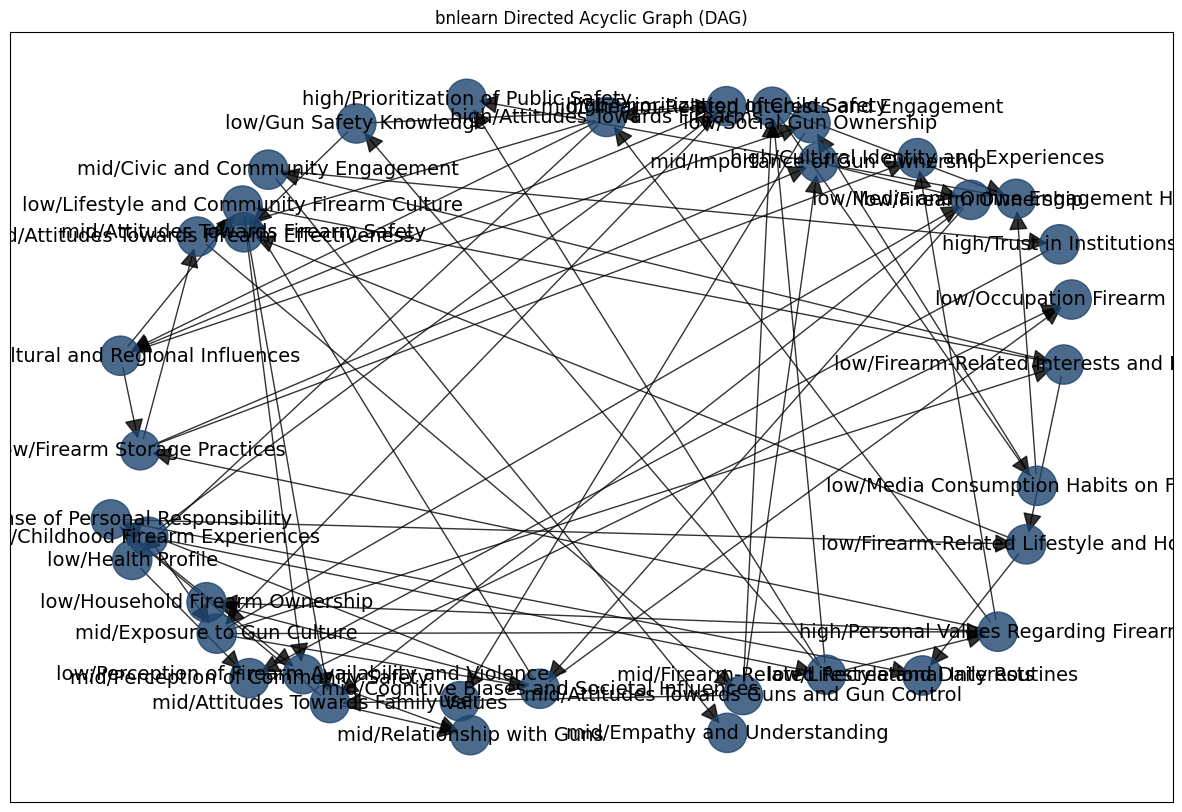

[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Edge [high/Trust in Institutions <-> mid/Perception of Community Safety] [P=0.521842] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Firearm-Related Recreational Interests <-> high/Prioritization of Public Safety] [P=0.843487] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Civic and Community Engagement <-> mid/Empathy and Understanding] [P=1] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Civic and Community Engagement <-> high/Trust in Institutions] [P=1] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Cognitive Biases and Societal Influences <-> low/Occupation Firearm Use] [P=1] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [low/Firearm-Related Lifestyle and Hobbies <-> mid/Attitudes Towards Firearm Safety] [P=

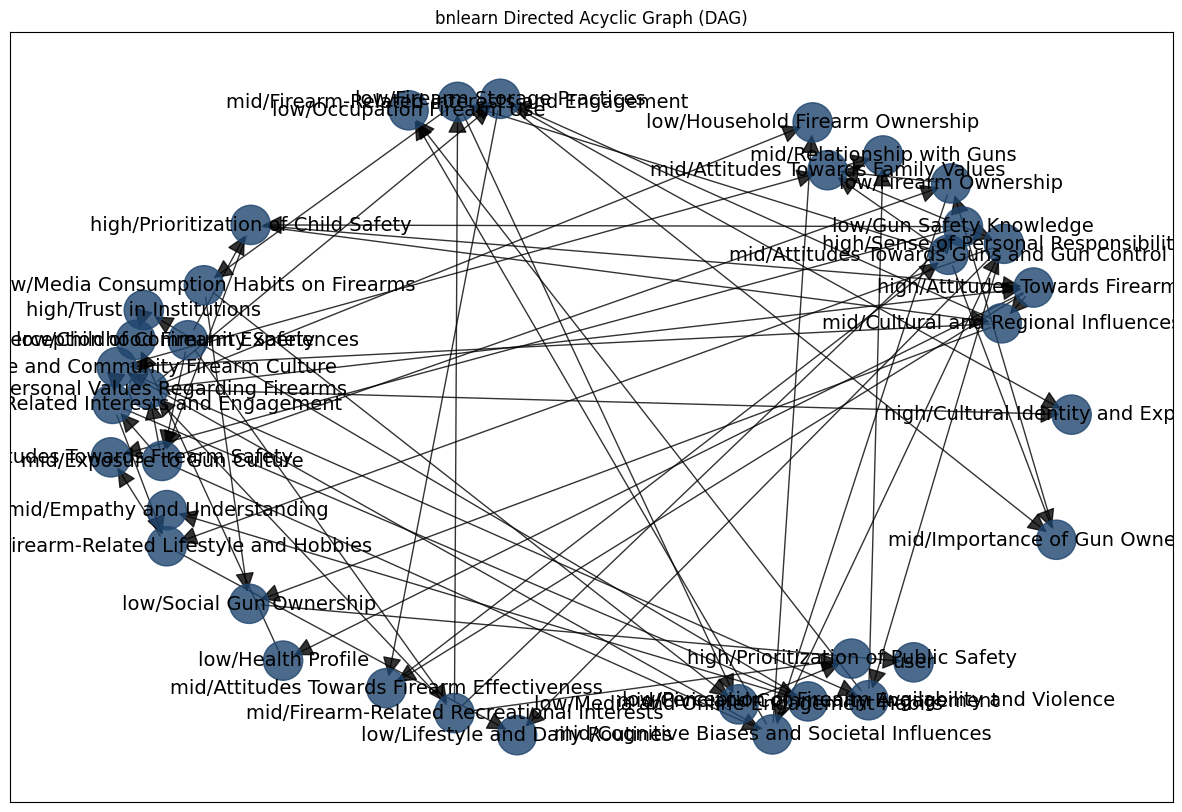

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of high/Personal Values Regarding Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Attitudes Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Cultural Identity and Experiences:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of low/Household Firearm Ownership:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of low/Firearm Storage Practices:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of mid/Cultural and Regional Influences:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| 

In [20]:
new_param_model, new_dirs = get_bn(cat_new_raw_df, method='hc', score='bds')

In [21]:
get_topo(new_param_model)

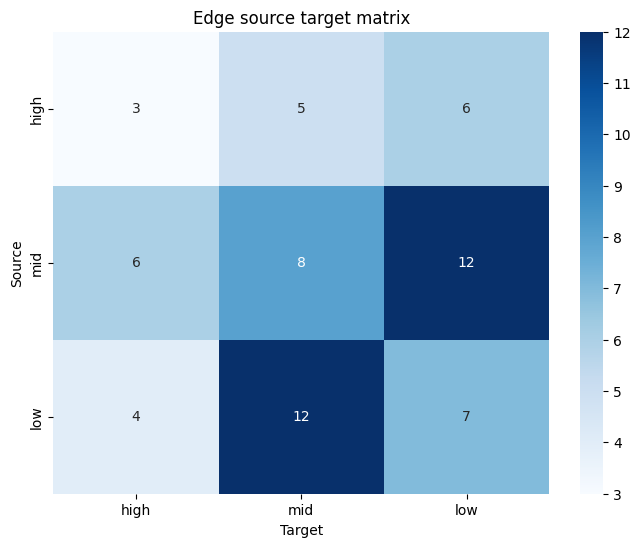

In [24]:
get_matrix(new_dirs)

# Output raw_df

In [22]:

for _, row in raw_df.iterrows():
    user = str(row['user'])
    personas = categorized_data[user]
    for idx, p in enumerate(personas):
        val = row[f"{p['level']}/{p['name']}"]
        # mapping = idx2opt_mapping[f"{p['level']}/{p['name']}"]
        # new_val = mapping[val]
        # categorized_data[user][idx]['inferred_value'] = new_val
        categorized_data[user][idx]['inferred_value'] = val

new_persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0830_personas_testonly_haiku_bn_hcbds_em7.json'

# with open(new_persona_filename, 'w') as f:
#     json.dump(categorized_data, f, indent=4)

# Temp General

In [23]:
# import os
# os.chdir("/home/ubuntu/code/pump_post_midterm/pump")

# import json
# import bnlearn as bn
# import pandas as pd
# import networkx as nx
# from tqdm import tqdm


# for score in tqdm(['k2']):

#     persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0729_midterm_personas_full_sonnet.json'

#     with open(persona_filename, 'r') as f:
#         data = json.load(f)
#     data[list(data.keys())[0]]

#     # clean data

#     def clean(data):
#         for user in data.keys():
#             personas = data[user]
#             clean = []
#             for p in personas:
#                 inf_val = p['inferred_value']
#                 cands = p['candidate_values']
#                 if inf_val not in cands:
#                     if inf_val[1:-1] in cands and all(_ in ['\'', '\"'] for _ in [inf_val[0], inf_val[-1]]):
#                         p['inferred_value'] = inf_val[1:-1]
#                         clean.append(p)
#                 else:
#                     clean.append(p)
#             data[user] = clean

#     clean(data)

#     # categorize_data

#     idx2opt_mapping = {}
#     opt2idx_mapping = {}

#     for persona in data[list(data.keys())[0]]:
#         p_name = persona['name']
#         cands = persona['candidate_values']
#         idx2opt = {k+1: v for k, v in enumerate(cands)}  # 0 for potential NAs
#         idx2opt[0] = "Unknown"
#         idx2opt_mapping[p_name] = idx2opt
#         opt2idx_mapping[p_name] = {v: k for k, v in idx2opt.items()}

#     def categorize(data):
#         for user in data:
#             personas = data[user]
#             clean = []
#             for p in personas:
#                 p_name = p['name']
#                 inf_val = p['inferred_value']
#                 p['inferred_value'] = opt2idx_mapping[p_name][inf_val]
#                 clean.append(p)
#             data[user] = clean

#     categorize(data)



#     def get_bn(df, method, score):

#         model = bn.structure_learning.fit(df, methodtype=method, scoretype=score)
#         # Plot detected DAG
#         pos = nx.spring_layout(model['adjmat'])
#         # G = bn.plot(model, pos=pos)
#         # dirs = []
#         # for edge in G['edge_properties']:
#         #     s, t = edge
#         #     s = s.split('/')[0]
#         #     t = t.split('/')[0]
#         #     dirs.append(f"{s}_{t}")
#         # from collections import Counter
#         # sorted(Counter(dirs).items())


#         # Compute edge strength using chi-square independence test
#         model1 = bn.independence_test(model, df, alpha=0.05, prune=True)
#         pos = nx.spring_layout(model['adjmat'])
#         # G1 = bn.plot(model, pos=pos)
#         # dirs = []
#         # for edge in G1['edge_properties']:
#         #     s, t = edge
#         #     s = s.split('/')[0]
#         #     t = t.split('/')[0]
#         #     dirs.append(f"{s}_{t}")
#         # from collections import Counter
#         # sorted(Counter(dirs).items())


#         param_model = bn.parameter_learning.fit(model1, df)

#         return param_model



#     res = []
#     for user in data.keys():
#         entry = {'user': user}
#         for persona in data[user]:
#             entry[f"{persona['level']}/{persona['name']}"] = persona['inferred_value']
#         res.append(entry)

#     raw_df = pd.DataFrame(res)
#     raw_df.fillna(0, inplace=True)
#     raw_df = raw_df.astype(int)
#     df = raw_df[[_ for _ in raw_df.columns if _ != "user"]]
#     df

#     param_model = get_bn(df, method='hc', score=score)

#     for _ in range(1):
#         Xtest = bn.sampling(param_model, 10)
#         cols = Xtest.columns
#         variables=[col for col in cols if col.startswith('mid') or col.startswith('high')]
#         for var in tqdm(variables):
#             Pout = bn.predict(param_model, df[[col for col in cols if col not in variables]], variables=[var])
#             df[var] = Pout[var]
#             raw_df[var] = Pout[var]
        
#         # param_model = get_bn(df)

#     for _, row in raw_df.iterrows():
#         user = str(row['user'])
#         personas = data[user]
#         for idx, p in enumerate(personas):
#             val = row[f"{p['level']}/{p['name']}"]
#             mapping = idx2opt_mapping[p['name']]
#             new_val = mapping[val]
#             data[user][idx]['inferred_value'] = new_val

#     new_persona_filename = f'opinions_qa/persona_val/American_Trends_Panel_W26/date0826_personas_full_sonnet_bn_hc{score}.json'

#     with open(new_persona_filename, 'w') as f:
#         json.dump(data, f, indent=4)